In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import umap
import pandas as pd
import numpy as np

import mofaflex as mfl

/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

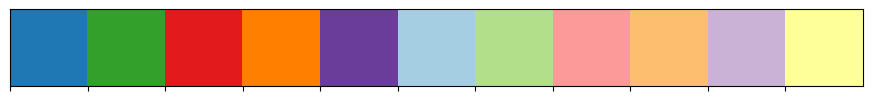

In [4]:
# # Discrete colors
# colors_disc = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33', '#A65628', '#F781BF', '#999999']

# # Continuous colors
# colors_div = ["#214D83", "#7D1B26"]  # blue, red


import matplotlib as mpl
from functools import partial
import numpy as np
from mizani.palettes import brewer_pal


CONSTANT_SIZE = 12

mpl.rcParams["svg.fonttype"] = "none"
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams["font.size"] = CONSTANT_SIZE
mpl.rcParams["axes.labelsize"] = CONSTANT_SIZE
mpl.rcParams["axes.titlesize"] = CONSTANT_SIZE
mpl.rcParams["xtick.labelsize"] = CONSTANT_SIZE
mpl.rcParams["ytick.labelsize"] = CONSTANT_SIZE
mpl.rcParams["legend.fontsize"] = CONSTANT_SIZE
mpl.rcParams["figure.titlesize"] = CONSTANT_SIZE

p9.options.base_family = "Helvetica"
th = p9.theme_bw(base_size=CONSTANT_SIZE, base_family="Helvetica") + p9.theme(
    line=p9.element_line(size=0.5),
    rect=p9.element_rect(size=0.5),
    panel_grid_minor=p9.element_blank(),
    panel_border=p9.element_line(),
    axis_ticks=p9.element_line(color="black"),
    axis_ticks_minor=p9.element_blank(),
    axis_text=p9.element_text(color="black", size=CONSTANT_SIZE),
    strip_background=p9.element_blank(),
    strip_text=p9.element_text(color="black", size=CONSTANT_SIZE),
    legend_text=p9.element_text(size=CONSTANT_SIZE),
    legend_key=p9.element_blank(),
    plot_title=p9.element_text(ha="center"),
    # aspect_ratio=1,
)
p9.theme_set(th)


def _rescale_zerosymmetric(x, to: tuple[float, float] = (0, 1), _from: tuple[float, float] | None = None):
    _from = _from or (np.min(x), np.max(x))
    return np.interp(x, (_from[0], 0, _from[1]), (0, 0.5, 1))

_scale_fill_zerosymmetric_diverging = partial(
    p9.scale_fill_gradientn,
    colors=brewer_pal(type="div", palette="RdBu", direction=-1)(11),
    rescaler=_rescale_zerosymmetric,
    expand=(0, 0),
)

_weights_inferred_color_scale = p9.scale_color_manual(
    values=("red", "black"), breaks=(True, False), labels=("Inferred", "Annotated")
)


DISCRETE_COLORS = [
    "#1f78b4",
    "#33a02c",
    "#e31a1c",
    "#ff7f00",
    "#6a3d9a",
    "#a6cee3",
    "#b2df8a",
    "#fb9a99",
    "#fdbf6f",
    "#cab2d6",
    "#ffff99",
]

# DISCRETE_COLORS = [
#     "#a6cee3",
#     "#b2df8a",
#     "#fb9a99",
#     "#fdbf6f",
#     "#cab2d6",
#     "#ffff99",
#     "#1f78b4",
#     "#33a02c",
#     "#e31a1c",
#     "#ff7f00",
#     "#6a3d9a",
#     "#b15928",
# ]

GREY_COLOR = "#d3d3d3"

discrete_scale_fill = p9.scale_fill_manual(values=DISCRETE_COLORS)
discrete_scale_color = p9.scale_color_manual(values=DISCRETE_COLORS)

sns.palplot(DISCRETE_COLORS)

In [5]:
data = {
    "group_xenium": {"rna": sc.read_h5ad("data/xenium.h5ad")},
    "group_chromium": {"rna": sc.read_h5ad("data/chromium.h5ad")}
}
data

{'group_xenium': {'rna': AnnData object with n_obs × n_vars = 167780 × 313
      obs: 'celltype', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
      var: 'symbol'
      uns: 'log1p'
      obsm: 'spatial'
      layers: 'counts'},
 'group_chromium': {'rna': AnnData object with n_obs × n_vars = 30365 × 18082
      obs: 'celltype'
      var: 'symbol'
      uns: 'log1p'
      layers: 'counts'}}

In [6]:
remove_idx = pd.read_csv("data/remove_idx.csv", index_col=0)["0"].astype(str)
keep_idx = pd.Index([on for on in data["group_xenium"]["rna"].obs_names if on not in remove_idx])
len(keep_idx)

167780

In [7]:
data["group_xenium"]["rna"] = data["group_xenium"]["rna"][keep_idx, :].copy()

feature_vars = data["group_chromium"]["rna"].to_df().var()
print((feature_vars > 0).mean())

data["group_chromium"]["rna"] = data["group_chromium"]["rna"][
    :, feature_vars.sort_values(ascending=False).iloc[:3000].index
].copy()
data["group_chromium"]["rna"].var_names = (
    data["group_chromium"]["rna"].var["symbol"].astype(str)
)
data["group_xenium"]["rna"].var_names = (
    data["group_xenium"]["rna"].var["symbol"].astype(str)
)
data

0.9786528038933746


{'group_xenium': {'rna': AnnData object with n_obs × n_vars = 167780 × 313
      obs: 'celltype', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
      var: 'symbol'
      uns: 'log1p'
      obsm: 'spatial'
      layers: 'counts'},
 'group_chromium': {'rna': AnnData object with n_obs × n_vars = 30365 × 3000
      obs: 'celltype'
      var: 'symbol'
      uns: 'log1p'
      layers: 'counts'}}

In [8]:
random_samples_xenium = pd.Series(data["group_xenium"]["rna"].obs_names).sample(2000)
random_samples_chromium = pd.Series(data["group_chromium"]["rna"].obs_names).sample(1000)
data = {"group_xenium": {"rna": data["group_xenium"]["rna"][random_samples_xenium, :]}, "group_chromium": {"rna": data["group_chromium"]["rna"][random_samples_chromium, :]}}
data

{'group_xenium': {'rna': View of AnnData object with n_obs × n_vars = 2000 × 313
      obs: 'celltype', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
      var: 'symbol'
      uns: 'log1p'
      obsm: 'spatial'
      layers: 'counts'},
 'group_chromium': {'rna': View of AnnData object with n_obs × n_vars = 1000 × 3000
      obs: 'celltype'
      var: 'symbol'
      uns: 'log1p'
      layers: 'counts'}}

In [9]:
def to_upper(feature_set_collection):
    return mfl.FeatureSets(
        [
            mfl.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

hallmark_collection = mfl.FeatureSets.from_gmt(
    "../msigdb/h.all.v7.5.1.symbols.gmt", name="hallmark"
)

reactome_collection = mfl.FeatureSets.from_gmt(
    "../msigdb/c2.cp.reactome.v7.5.1.symbols.gmt", name="reactome"
)

kegg_collection = mfl.FeatureSets.from_gmt(
    "../msigdb/c2.cp.kegg.v7.5.1.symbols.gmt", name="kegg"
)

# celltype_collection = pd.read_csv(
#     "adipose_markers.txt", sep="\t", comment="#", header=None
# )
# celltype_collection[1] = celltype_collection[1].str.split(",")
# celltype_collection = mfl.FeatureSets.from_dataframe(
#     celltype_collection, name="celltype", name_col=0, features_col=1
# )

# merge both collections
gene_set_collection = hallmark_collection
gene_set_collection = to_upper(gene_set_collection)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection



gene_set_collection = gene_set_collection.filter(
    data["group_chromium"]["rna"].var_names,
    min_fraction=0.2,
    min_count=40,
    max_count=300,
    # keep=keep,
)
sorted([(len(fs), fs.name) for fs in gene_set_collection])

[(40, 'HALLMARK_INTERFERON_ALPHA_RESPONSE'),
 (40, 'HALLMARK_UV_RESPONSE_UP'),
 (41, 'HALLMARK_COAGULATION'),
 (41, 'HALLMARK_PROTEIN_SECRETION'),
 (43, 'HALLMARK_INFLAMMATORY_RESPONSE'),
 (44, 'HALLMARK_ANDROGEN_RESPONSE'),
 (44, 'HALLMARK_HEME_METABOLISM'),
 (45, 'HALLMARK_E2F_TARGETS'),
 (46, 'HALLMARK_ESTROGEN_RESPONSE_EARLY'),
 (46, 'HALLMARK_GLYCOLYSIS'),
 (49, 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE'),
 (50, 'HALLMARK_MYOGENESIS'),
 (54, 'HALLMARK_ADIPOGENESIS'),
 (54, 'HALLMARK_G2M_CHECKPOINT'),
 (56, 'HALLMARK_ESTROGEN_RESPONSE_LATE'),
 (56, 'HALLMARK_UV_RESPONSE_DN'),
 (60, 'HALLMARK_HYPOXIA'),
 (60, 'HALLMARK_IL2_STAT5_SIGNALING'),
 (60, 'HALLMARK_KRAS_SIGNALING_UP'),
 (60, 'HALLMARK_MYC_TARGETS_V1'),
 (63, 'HALLMARK_ALLOGRAFT_REJECTION'),
 (64, 'HALLMARK_OXIDATIVE_PHOSPHORYLATION'),
 (65, 'HALLMARK_P53_PATHWAY'),
 (66, 'HALLMARK_APICAL_JUNCTION'),
 (69, 'HALLMARK_COMPLEMENT'),
 (69, 'HALLMARK_MTORC1_SIGNALING'),
 (72, 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'),
 (76, 'HALLMARK_APOPTOS

In [10]:
data["group_xenium"]["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    data["group_xenium"]["rna"].var_names.tolist()
).T

/tmp/ipykernel_3975639/2230487522.py:1: ImplicitModificationWarning: Setting element `.varm['gene_set_mask']` of view, initializing view as actual.


In [11]:
device = "cpu"
try:
    device = f"cuda:{mfl.tl.get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:1'

In [12]:
data_opts = mfl.DataOptions(
    group_by=None,
    scale_per_group=True,
    annotations_varm_key={"rna": "gene_set_mask"},
    covariates_obs_key=None,
    covariates_obsm_key={"group_xenium": "spatial", "group_chromium": None},
    use_obs="union",
    use_var="union",
    plot_data_overview=False,
)

model_opts = mfl.ModelOptions(
    n_factors=3,
    weight_prior="Horseshoe",
    factor_prior={"group_xenium": "GP", "group_chromium": "Normal"},
    likelihoods="Normal",
    nonnegative_weights=True,
    nonnegative_factors=True,
    prior_penalty=0.001,
    init_factors=0.0,
    init_scale=0.1,
)

training_opts = mfl.TrainingOptions(
    device=device,
    batch_size=500,
    max_epochs=200,
    n_particles=1,
    lr=0.003,
    early_stopper_patience=10,
    save_path=None,
    seed=None,
)

smooth_opts = mfl.SmoothOptions(
    n_inducing=400,
    kernel="RBF",
    warp_groups=[],
    warp_interval=20,
    warp_open_begin=True,
    warp_open_end=True,
    warp_reference_group=None,
)

model = mfl.MOFAFLEX(data, data_opts, model_opts, training_opts, smooth_opts)

WARNING	Could not import dask. Data arrays may be copied, resulting in high memory usage.
/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
INFO	Initializing factors using `0.0` method...
  0%|          | 0/200 [00:00<?, ?epochs/s]/home/aqoku/miniforge3/envs/mofaflex_exp/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
/home/aqoku/miniforge

RuntimeError: shape '[34, 2000, 1]' is invalid for input of size 17000
                                                                         Trace Shapes:                   
                                                                          Param Sites:                   
      _factors.0._gp$$$variational_strategy._variational_distribution.variational_mean      34 400       
_factors.0._gp$$$variational_strategy._variational_distribution.chol_variational_covar 34  400 400       
                              _factors.0._gp$$$_covar_module.group_kernel.covar_factor 34    1   1       
                                   _factors.0._gp$$$_covar_module.group_kernel.raw_var      34   1       
                            _factors.0._gp$$$_covar_module.base_kernel.raw_outputscale          34       
                _factors.0._gp$$$_covar_module.base_kernel.base_kernel.raw_lengthscale 34    1   1       
                                                                         Sample Sites:                   
                                                       plate_samples_group_xenium dist           |       
                                                                                 value     500   |       
                                                     plate_samples_group_chromium dist           |       
                                                                                 value     500   |       
                                                               plate_features_rna dist           |       
                                                                                 value    3209   |       
                                                               plate_guiding_vars dist           |       
                                                                                 value       1   |       
                                                                    plate_factors dist           |       
                                                                                 value      34   |       
                                                                             gp.u dist           | 34 400
                                                                                 value           | 34 400
                                                                     gp.log_prior dist           |  0    
                                                                                 value           |  0    
                                                                    gp.added_loss dist           |  0    
                                                                                 value           |  0    
                                                                         gp_batch dist           |       
                                                                                 value      34   |       
                                                                             gp.f dist 34  500   |       
                                                                                 value 34  500   |       